In [1]:
import torch as tc
import torch.nn as nn
from torch import Tensor
import pandas as pd
import numpy as np
import os
from skimage import io
import matplotlib.pyplot as plt
import cv2 
import torchvision

In [2]:
path_to_dataset = r'DATA' # Path to the downloaded and unzipped dataset

class OurDataset(tc.utils.data.Dataset):
    def __init__(self, dataset_path : str, mode : str="training"):
        self.dataset_path = dataset_path
        self.mode = mode # "training" or "testing"

        if self.mode == "training":
            self.data_path = os.path.join(self.dataset_path, "training")
        elif self.mode == "testing":
            self.data_path = os.path.join(self.dataset_path, "test")
        else:
            raise ValueError("Unsupported mode.")

        self.classes = os.listdir(self.data_path)
        print(f"Available classes: {self.classes}")
        self.classes_dict = {self.classes[i]: i for i in range(len(self.classes))}
        print(f"Classes dict: {self.classes_dict}")

        self.cases = []
        for current_class in self.classes:
            for current_case in os.listdir(os.path.join(self.data_path, current_class)):
                case_path = os.path.join(self.data_path, current_class, current_case)
                self.cases.append((case_path, self.classes_dict[current_class]))

    def __len__(self):
        return len(self.cases)
        

    def __getitem__(self, idx):

        dim1, dim2 = 224, 224
        current_case = self.cases[idx]
        current_path = current_case[0]
        current_class = current_case[1]
        current_image = io.imread(current_path)  
        current_image = np.repeat(current_image[..., np.newaxis], 3, -1)
        def rgb2gray(rgb):
          return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])
        #current_image = rgb2gray(current_image)
        current_image = cv2.resize(current_image, (dim1, dim2), interpolation = cv2.INTER_AREA)    
        current_image = current_image.reshape(3,dim1, dim2)
        current_image = current_image.astype(np.float32)
        current_image = current_image/255.0
    
        return current_image, current_class

In [3]:
training_dataset = OurDataset(path_to_dataset, "training") # Utworzenie zbioru treningowego
testing_dataset = OurDataset(path_to_dataset, "testing") # Utworzenie zbioru testowego
batch_size = 16 # Okreslenie ile przypadkow ma byc naraz wczytywane i procesowane -> istotny hyperparameter w trakcie treningu
shuffle = True # Czy przypadki w każdej epocje mają być wczytywane losowo. Epoka - każdorazowe przeiterowanie przez cały zbiór treningowy
training_dataloader = tc.utils.data.DataLoader(training_dataset, batch_size=batch_size, shuffle=shuffle)
testing_dataloader = tc.utils.data.DataLoader(testing_dataset, batch_size=1, shuffle=False)

Available classes: ['Homm', 'No_homm']
Classes dict: {'Homm': 0, 'No_homm': 1}
Available classes: ['Homm', 'No_homm']
Classes dict: {'Homm': 0, 'No_homm': 1}


In [10]:
class FirstModel(tc.nn.Module):
    def __init__(self):
        super(FirstModel, self).__init__()

        self.model = torchvision.models.densenet121(weights='DEFAULT')

        ct = 0
        for child in self.model.children():
            ct = ct + 1
            print(ct)
            if ct < 2:
                for param in child.parameters():
                    param.requires_grad = False
            
        self.layer_1 = tc.nn.Sequential(
            tc.nn.Linear(1000, 64),
            tc.nn.Sigmoid()
        ) 
        self.layer_2 = tc.nn.Sequential(
            tc.nn.Linear(64, 2)
        )
        

    def forward(self, x): 
        x = self.model(x)
        x = self.layer_1(x)
        x = self.layer_2(x)
        return x

In [11]:
#learning_rate = 0.005 # Współczynnik uczenia, definiuje szybkość treningu, zbyt duży prowadzi do niestabilności, zbyt niski do wolnego uczenia
batch_size = 32 # Liczba obrazów analizowanych w zadanym momencie - większa wartość prowadzi do lepszego wykorzystania GPU, jednak może powodować większy potencjał do wpadania w minima lokalne
num_epochs = 10 # Liczba iteracji przez cały zbiór treningowy
objective_function = tc.nn.CrossEntropyLoss() # Funkcja kosztu, która będzie minimalizowana
model = FirstModel()
#model.load_state_dict(tc.load('densenet_start.pt'))
#model.eval()
parameters = model.parameters()
#parameters = 
#optimizer = tc.optim.Adam(parameters, lr=learning_rate) # Utworzenie obiektu optymalizatora -> w tym przypadku Adam (najpopularniejszy), w uproszczeniu - bardziej zaawansowany wariant spadku gradientowego
optimizer = tc.optim.SGD(model.parameters(), lr=0.01, weight_decay=0.01, momentum=0.7)
device = "cuda:0" # Urządzenie, na którym będzie prowadzony trening, użyjmy karty graficznej, ew. zmienić na "cpu" w przypadku jej braku. Karty graficzne są dostępnę na Google Colaboratory

training_dataset = OurDataset(path_to_dataset, "training")
test_dataset = OurDataset(path_to_dataset, "testing")
shuffle = True 
training_dataloader = tc.utils.data.DataLoader(training_dataset, batch_size=batch_size, shuffle=shuffle)
test_dataloader = tc.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

1
2
Available classes: ['Homm', 'No_homm']
Classes dict: {'Homm': 0, 'No_homm': 1}
Available classes: ['Homm', 'No_homm']
Classes dict: {'Homm': 0, 'No_homm': 1}


In [12]:
for images, classes in training_dataloader:
    output = model(images) # <- Kluczowa linijka kodu, wywołanie funkcji **forward** z klasy SimpleNetwork
    print(f"Output: {tc.nn.Sigmoid()(output)}") # <- w praktyce Sigmoid w celu wyznaczania prawdopodobieństwa umieszcza się poza siecią neuronową
    break

Output: tensor([[0.5647, 0.5922],
        [0.5136, 0.5656],
        [0.5359, 0.5936],
        [0.5096, 0.5682],
        [0.4981, 0.5739],
        [0.4966, 0.5928],
        [0.5375, 0.5847],
        [0.5134, 0.5922],
        [0.4958, 0.5661],
        [0.5076, 0.5572],
        [0.5396, 0.5939],
        [0.5093, 0.5457],
        [0.5509, 0.5683],
        [0.5022, 0.5412],
        [0.5399, 0.5579],
        [0.5330, 0.5928],
        [0.5388, 0.5311],
        [0.5330, 0.6031],
        [0.4955, 0.5442],
        [0.5120, 0.5858],
        [0.5217, 0.5561],
        [0.5506, 0.6142],
        [0.5100, 0.5722],
        [0.4886, 0.5417],
        [0.5430, 0.5797],
        [0.5107, 0.5470],
        [0.5310, 0.6002],
        [0.5445, 0.5785],
        [0.5196, 0.5991],
        [0.4849, 0.5788],
        [0.5423, 0.5647],
        [0.5165, 0.5795]], grad_fn=<SigmoidBackward0>)


Dataset size: 2361
Current epoch: 0
Current epoch loss: 0.5102561803022616
Current epoch loss: 0.5102561803022616   Current validation loss: 0.7085223036735803
Current epoch: 1
Current epoch loss: 0.5099403310483515
Current epoch loss: 0.5099403310483515   Current validation loss: 0.7168125438570777
Current epoch: 2
Current epoch loss: 0.511551376648345
Current epoch loss: 0.511551376648345   Current validation loss: 0.70418392318318
Current epoch: 3
Current epoch loss: 0.5069968048317459
Current epoch loss: 0.5069968048317459   Current validation loss: 0.7106860477060627
Current epoch: 4
Current epoch loss: 0.5094202791215605
Current epoch loss: 0.5094202791215605   Current validation loss: 0.7169559806933586
Current epoch: 5
Current epoch loss: 0.5064131887673019
Current epoch loss: 0.5064131887673019   Current validation loss: 0.7149750379369733
Current epoch: 6
Current epoch loss: 0.504473367140284
Current epoch loss: 0.504473367140284   Current validation loss: 0.7081503067072326


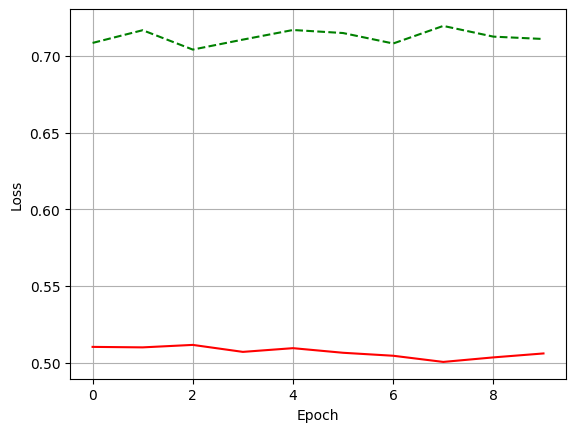

In [26]:
import torch.optim as optim
losses = []
val_losses = []
#optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_cen = tc.nn.CrossEntropyLoss()

#loss_cen = tc.nn.BCEWithLogitsLoss()
model = model.to(device) # Transfer sieci do pamięci urządzenia (np. GPU)

model.train()
print(f"Dataset size: {len(training_dataloader.dataset)}")
for epoch in range(num_epochs):
    print(f"Current epoch: {epoch}")
    epoch_loss = 0.0
    number = 0
    for images, classes in training_dataloader:
        images, classes = images.to(device), classes.to(device) # Transfer obrazów do pamięci urządzenia (np. GPU)
        output = model(images) # Przejście obrazów przez model
        loss = loss_cen(tc.nn.Sigmoid()(output), classes)# - wyznacz aktualna funkcje kosztu
        loss.backward() # - dokonaj backpropagacji gradientu wykorzystując wyznaczona wartosc kosztu
        optimizer.step()  # TODO - dokonaj aktualizacji optymalizatora
        optimizer.zero_grad()
        pass # TODO - wyzeruj historie gradientu w optymalizatorze
        epoch_loss += loss.item() * images.size(0)

        #print(number)
        number = number+1
    epoch_loss = epoch_loss / len(training_dataloader.dataset)
    losses.append(epoch_loss)
    threshold  = 1.0
    val_loss = 0.0
    number = 0
    print(f"Current epoch loss: {epoch_loss}")
    yes = True
    if yes:
        for images, classes in test_dataloader:
            images, classes = images.to(device), classes.to(device) # Transfer obrazów do pamięci urządzenia (np. GPU)
            output = model(images) # Przejście obrazów przez model
            loss = loss_cen(tc.nn.Sigmoid()(output), classes)# - wyznacz aktualna funkcje kosztu
            val_loss += loss.item() * images.size(0)
            #print(number)
            number = number+1
        val_loss = val_loss / len(test_dataloader.dataset)
        val_losses.append(val_loss)
    print(f"Current epoch loss: {epoch_loss}   Current validation loss: {val_loss}")
    
    if val_loss<threshold:
        threshold = val_loss
        tc.save(model.state_dict(), 'densenet_start.pt')
    

    


# Wizualizacja pętli treningowej
print(threshold)
plt.figure()
plt.plot(losses, "r-")
plt.plot(val_losses, 'g--')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

Dataset size: 2361
Accuracy = 0.8403218975010589
Recall = 0.8204936424831712


<Axes: >

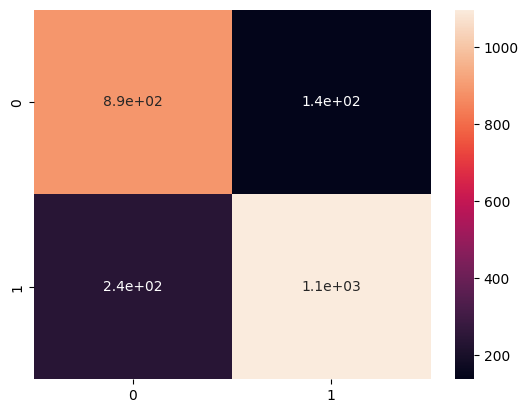

In [27]:
import sklearn.metrics as metrics
from torch import Tensor
import seaborn as sns

predictions = []
targets = []
model.eval()
with tc.set_grad_enabled(False):
    print(f"Dataset size: {len(training_dataloader.dataset)}")
    for images, classes in training_dataloader:
        images, classes = images.to(device), classes.to(device)
        output = model(images)
        prediction = tc.argmax(tc.nn.Sigmoid()(output), dim=1)
        predictions.append(Tensor.cpu(prediction))
        targets.append(Tensor.cpu(classes))

pred = []
targ = []      
for i,j  in zip(predictions, targets):
  for a, b in zip(i, j):
    pred.append(a)
    targ.append(b)




cf_matrix = metrics.confusion_matrix(targ, pred)
print("Accuracy = " + str(metrics.accuracy_score(targ, pred)))
print("Recall = " + str(metrics.recall_score(targ, pred)))


sns.heatmap(cf_matrix, annot=True)

Dataset size: 599
Accuracy = 0.7779632721202003
Recall = 0.7830985915492957


<Axes: >

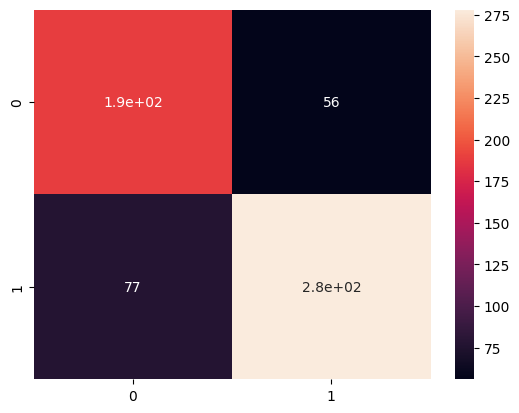

In [28]:
predictions = []
targets = []
model.eval()
with tc.set_grad_enabled(False):
    print(f"Dataset size: {len(testing_dataloader.dataset)}")
    for images, classes in testing_dataloader:
        images, classes = images.to(device), classes.to(device)
        output = model(images)
        prediction = tc.argmax(tc.nn.Sigmoid()(output), dim=1)
        predictions.append(Tensor.cpu(prediction))
        targets.append(Tensor.cpu(classes))

pred = []
targ = []      
for i,j  in zip(predictions, targets):
  for a, b in zip(i, j):
    pred.append(a)
    targ.append(b)




cf_matrix = metrics.confusion_matrix(targ, pred)
print("Accuracy = " + str(metrics.accuracy_score(targ, pred)))
print("Recall = " + str(metrics.recall_score(targ, pred)))

sns.heatmap(cf_matrix, annot=True)

In [18]:
tc.save(model.state_dict(), 'densenet_start.pt')